In [313]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import matplotlib.dates as mdates

#Segoe UI font
plt.rcParams['font.family'] = 'Segoe UI'

#### Read SMI file

In [314]:
src_dir = r'W:\VUB\_main_research\mHM\mhm_outputs\mHM_EOBS\SMI_outputs'
smi_EOBS_masked = xr.open_dataset(os.path.join(src_dir, 'SMI.nc'), engine='netcdf4')
drought_ADM = pd.read_csv(os.path.join(src_dir, 'results_ADM.txt'), index_col=0, sep="\s+")

Text(0.5, 1.0, 'SMI 2013-06-01T00:00:00.000000000')

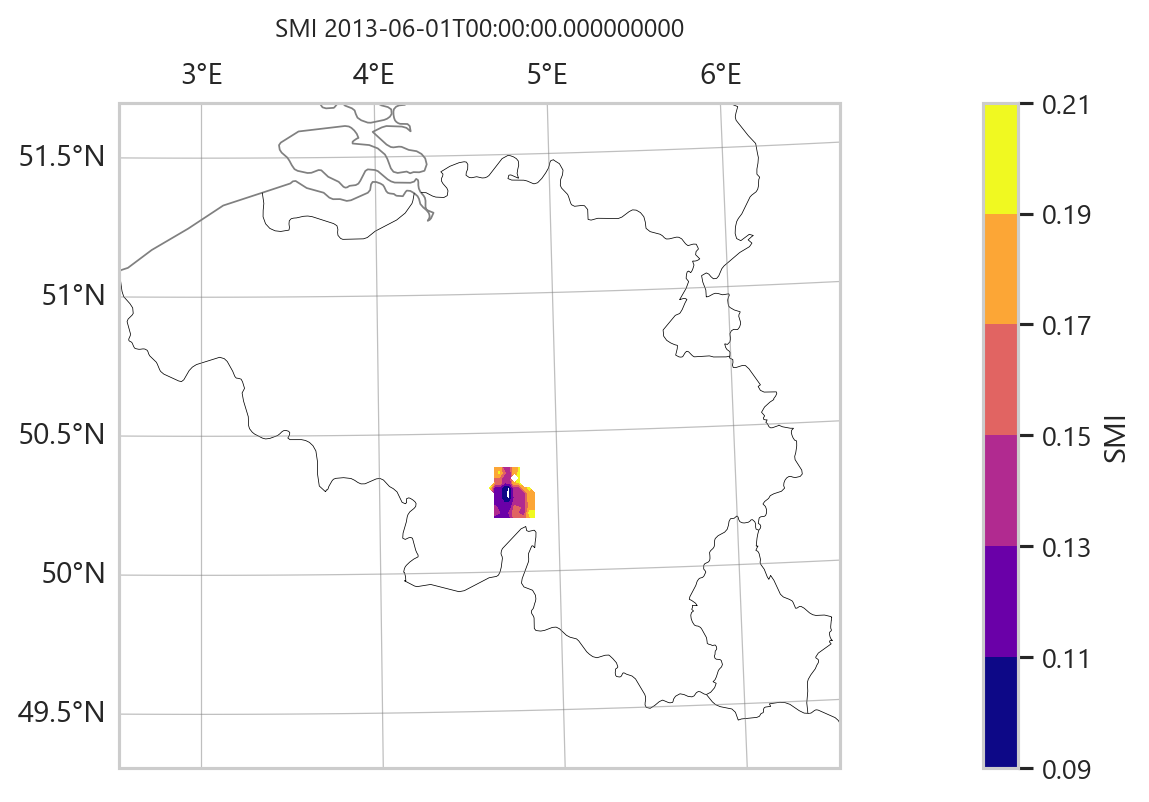

In [315]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.epsg(32631)}, dpi=180)

# Select time slice and filter for positive values
t = smi_EOBS_masked.SMI.isel(time=521)

#Ignre areas where variance is zero
smi_var = smi_EOBS_masked.SMI.var(dim='time')
t = t.where(smi_var > 0.001, drop=False)


t = t.where(t < .2, drop=False)

# Set extent for the map
grid_res= (t.lat[0] - t.lat[1]).values.item()  # Get grid resolution from latitude values
lat_min, lat_max = t.lat.min()+ grid_res*45, t.lat.max()-grid_res*20

lon_min, lon_max = t.lon.min()+ grid_res*20, t.lon.max()-grid_res*20

t_extent = t.sel(lat=slice(lat_max, lat_min), lon=slice(lon_min, lon_max))

# Set up contour levels safely
smi_min = np.round(float(t.min()), 2)
smi_max = np.round(float(t.max()), 2)


if np.isfinite(t.min()) and np.isfinite(t.max()):
    levels = np.arange(smi_min, smi_max + 0.01, 0.02)  # Create levels from min to max with step of 0.1
else:
    levels = 10  # fallback if data is empty

# Plot filled contours
im = t_extent.plot.contourf(
    ax=ax,
    cmap='plasma',
    transform=ccrs.epsg(32631),
    robust=True,
    add_colorbar=False,
    levels=levels,
    extend='neither'
)

# Add colorbar
cbar_ax = fig.add_axes([0.95, 0.11, 0.03, 0.77])   # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax, orientation='vertical', label='SMI', pad =0.5, aspect=30)

# Add coastlines and borders
ax.coastlines(color='gray', linewidth=0.7)
ax.add_feature(cfeature.BORDERS, linewidth=0.3)

# Add gridlines with labels
gl = ax.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels=True,
    linewidth=0.5,
    color='gray',
    alpha=0.5
)
gl.bottom_labels = False
gl.right_labels = False

# Add title
ax.set_title(f'SMI {t.time.values}', fontsize=10, pad=10)

#### Major droughts

In [316]:
#Assign dates to the drought periods
base_date = datetime(1970, 1, 31) #simulation starts from 1970-01-01, which is mStart=1, so we use 1969-12-31 as the base date

def add_months(months):
    return base_date + relativedelta(months=int(months)-1)

drought_ADM['start_month'] = drought_ADM['mStart'].map(add_months)
drought_ADM['end_month'] = drought_ADM['mEnd'].map(add_months)

In [317]:
top_TDM = drought_ADM.nlargest(7, 'TDM')

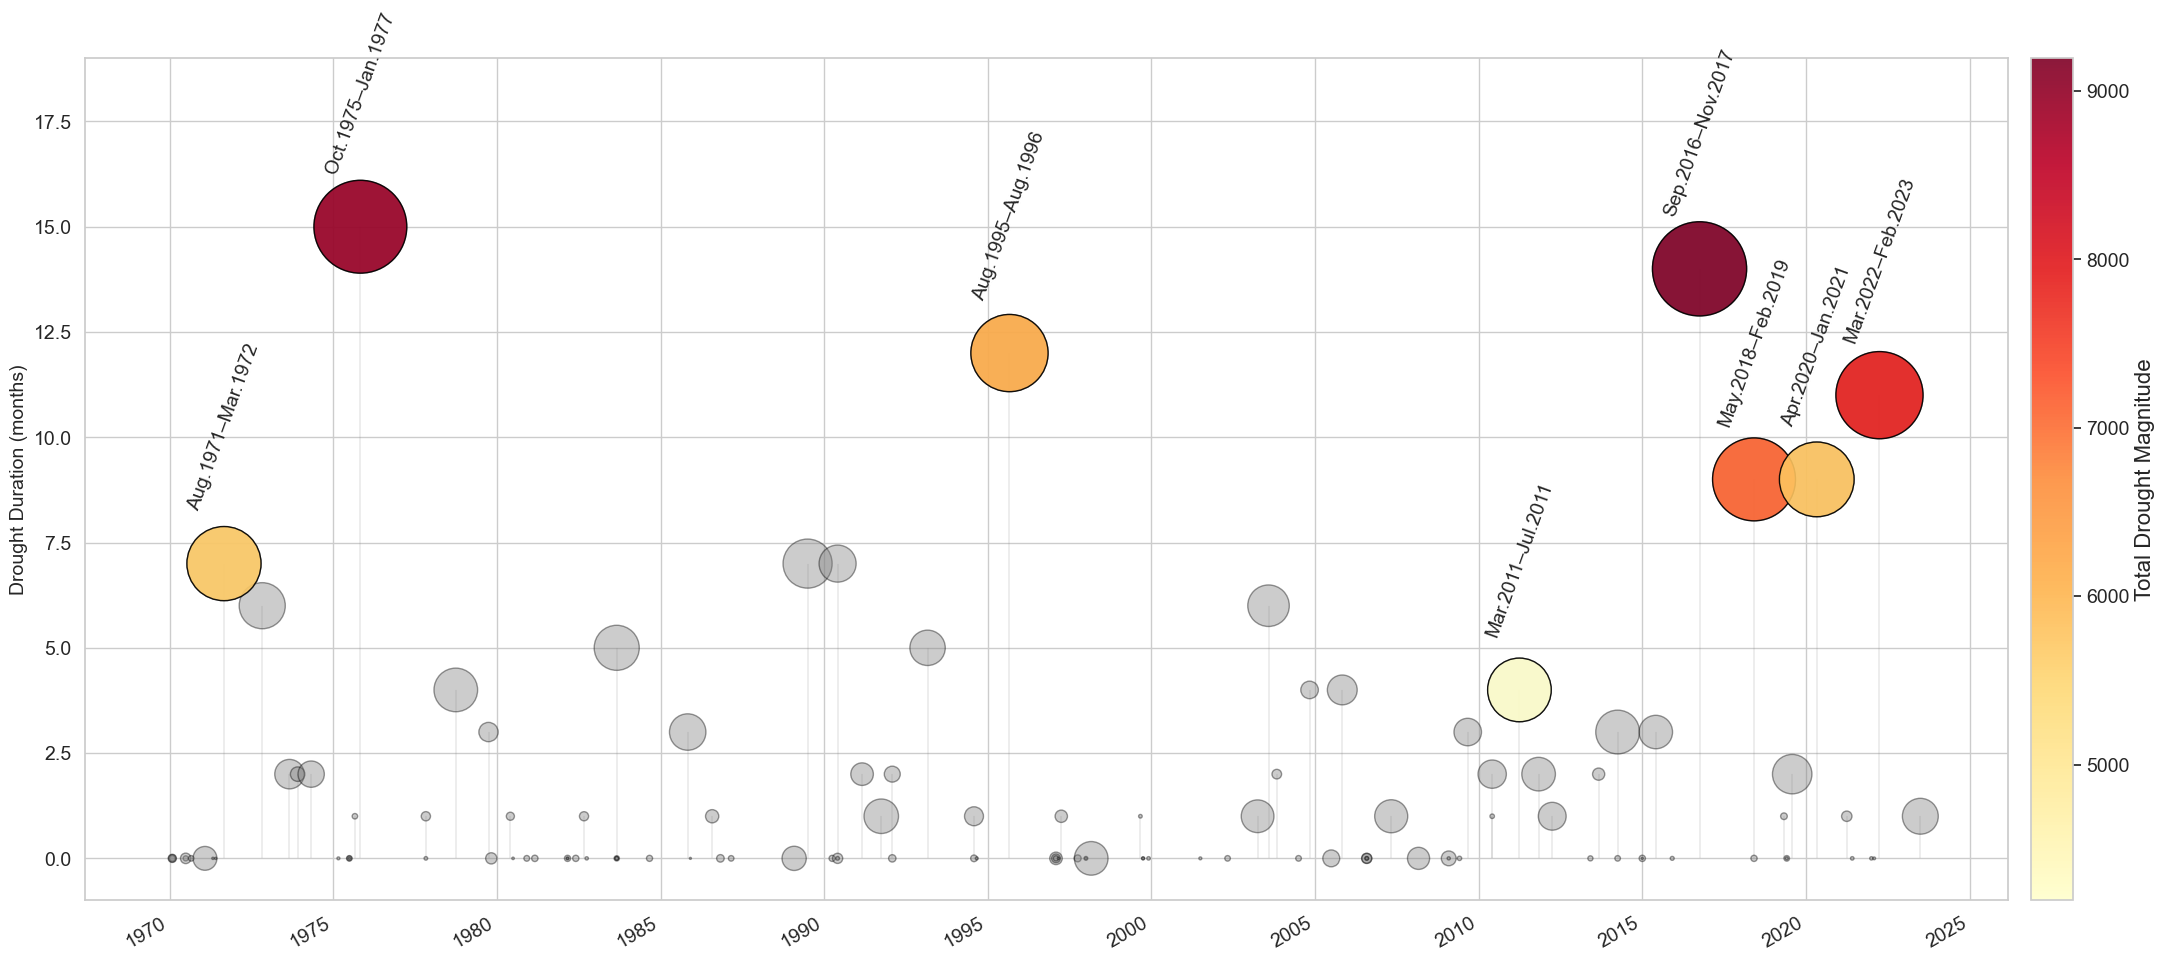

In [364]:

# Recalculate drought duration in months
drought_ADM["duration"] = (drought_ADM["end_month"] - drought_ADM["start_month"]).dt.days // 30  # approximate months
top_TDM = drought_ADM.nlargest(8, 'TDM')

# Plot with Y-axis as duration and stems from start to end
fig, ax = plt.subplots(figsize=(24, 10))
sns.set_style("whitegrid")

# Stems for all events representing duration
for _, row in drought_ADM.iterrows():
    ax.plot([row['start_month'], row['start_month']], [0, row['duration']],
            color='gray', linestyle='-', linewidth=0.2)

# Hollow black circles for all events
ax.scatter(drought_ADM['start_month'], drought_ADM['duration'],
           s=drought_ADM['TDM']/2, facecolors='gray', edgecolors='black', alpha=0.4, zorder=3, label='All Events')

# Top 10: fiery filled circles sized by TDM
sc = ax.scatter(top_TDM['start_month'], top_TDM['duration'],
                s=top_TDM['TDM'] / 2, c=top_TDM['TDM'], cmap='YlOrRd',
                edgecolor='black', alpha=0.9, zorder=5)

# Colorbar for TDM
cbar = plt.colorbar(sc, pad=0.01, aspect=20)
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Total Drought Magnitude', fontsize=16)

# Add labels below circles
for _, row in top_TDM.iterrows():
    label = f"{row['start_month'].strftime('%b.%Y')}–{row['end_month'].strftime('%b.%Y')}"
    ax.text(row['start_month'], row['duration'] + 1.2, label, fontsize=14, ha='center', va='bottom', rotation=70)

# Format axes
ax.set_ylim(-1, drought_ADM['duration'].max() + 4)
ax.set_ylabel("Drought Duration (months)", fontsize=14)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.xaxis.set_major_locator(mdates.YearLocator(5))
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

### Stacked Area Plot for SMI

In [404]:
def cluster_percentiles(xr_data, xr_var, percentiles, labels):
    """
    Calculate specified percentiles for each time step in the xarray DataArray.
    
    Parameters:
    xr_data (xarray.DataArray): Input data array with time dimension.
    percentiles (list): List of percentiles to calculate.
    labels (list): List of labels corresponding to the percentiles.
    
    Returns:
    df (pandas.DataFrame): DataFrame containing the percentiles for each time step.
    """
    # Group by year and classify data
    results = []
    for year, data in xr_data.groupby('time'):
        
        # Classify data into percentile bins
        binned = xr.apply_ufunc(
            np.digitize,
            data[xr_var],
            input_core_dims=[[]],
            kwargs={'bins': percentiles},
        )
        
        # Count the number of values in each bin
        counts = [(binned == i).sum().item() for i in range(1, len(percentiles))]
        results.append([year] + counts)

    # Convert results into a DataFrame
    df = pd.DataFrame(results, columns=['Year'] + labels)
    df=df.set_index('Year')

    #calculate the percentage of each category
    df_perc = df.div(df.sum(axis=1), axis=0) * 100

    return df_perc

In [438]:
variable = 'SMI'

#Mask the SMI data to ignore areas with zero variance
smi_EOBS_masked = smi_EOBS_masked.where(smi_EOBS_masked.SMI.var(dim='time') > 0.001, drop=False)

# Define the percentiles
bounds = [0.00, 0.02, 0.05, 0.10, 0.20, 0.30, 0.70, 0.95, 0.98, 1.0]
labels = ['Exceptional drought', 'Extreme drought', 'Severe drought',
          'Moderate drought', 'Abnormally dry','Normal conditions',
          'Wetter than normal', 'Very wet', 'Extremely wet']

# Calculate the percentiles
smi_percentile_df = cluster_percentiles(smi_EOBS_masked, variable, bounds, labels)

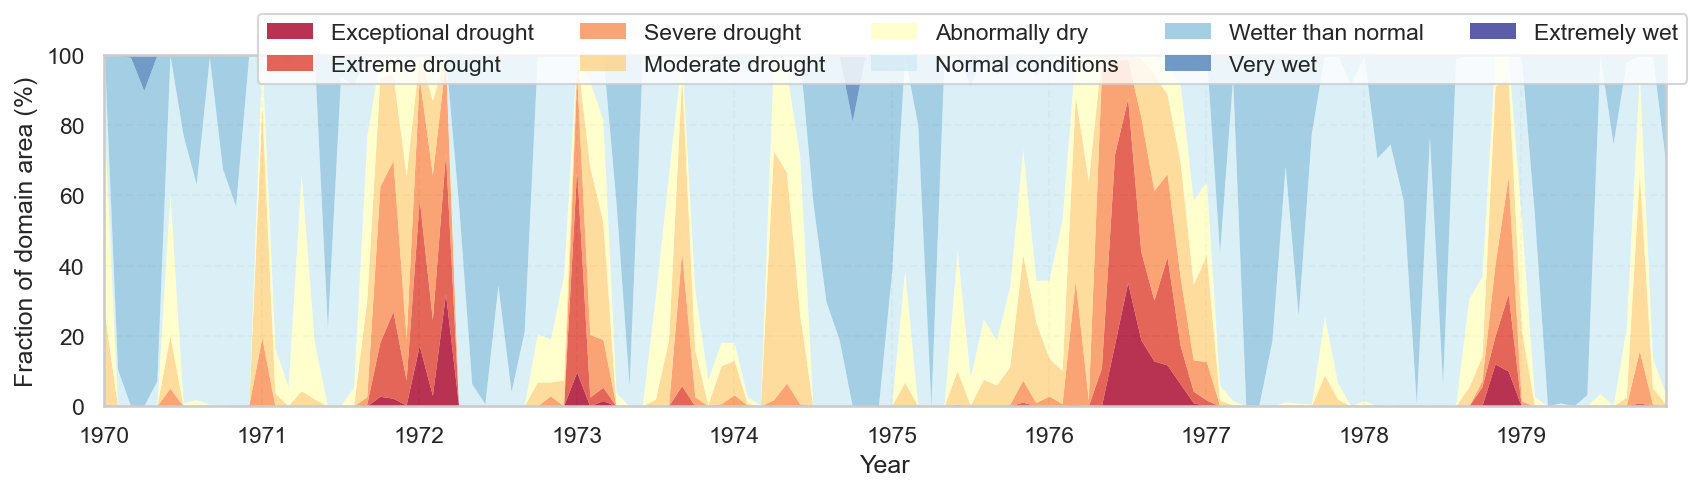

In [413]:
fig, ax = plt.subplots(figsize=(12, 3.5), dpi=150)
smi_percentile_df[0:120].plot.area(colormap='RdYlBu', ax=ax, linewidth=0, alpha=0.8)
plt.ylabel('Fraction of domain area (%)')
plt.ylim(0, 100)
plt.legend(loc='upper center', bbox_to_anchor=(0.556, 1.15), ncol=5)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

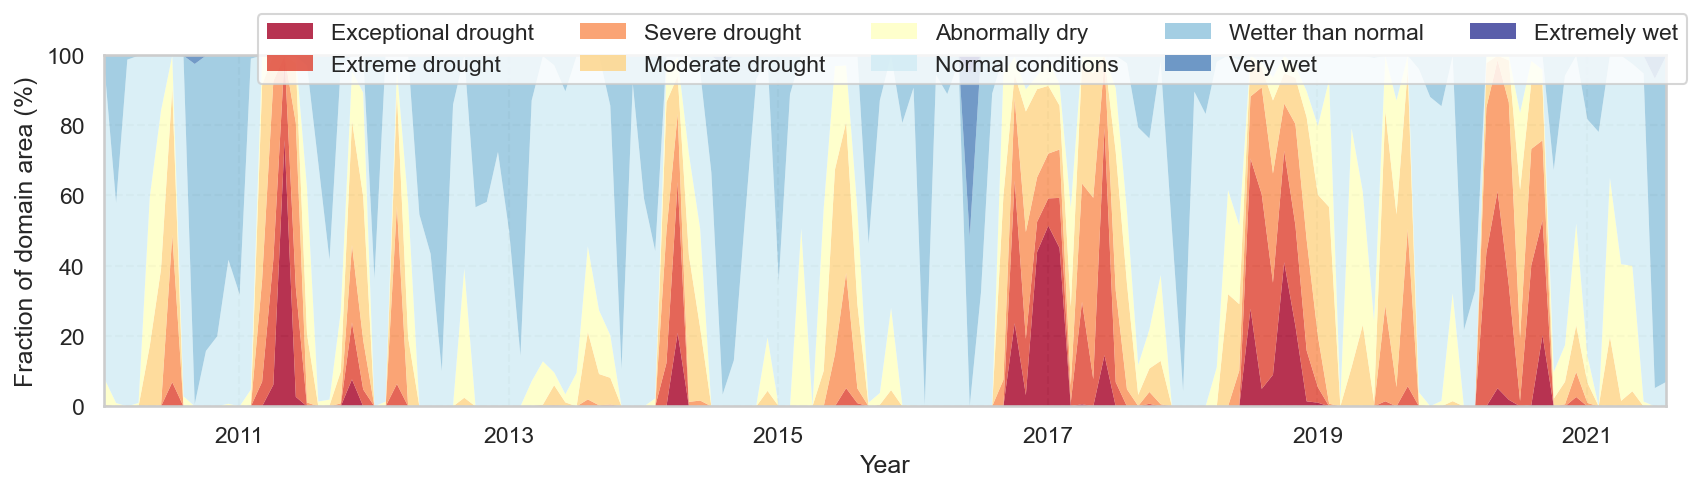

In [414]:
fig, ax = plt.subplots(figsize=(12, 3.5), dpi=150)
smi_percentile_df[480:620].plot.area(colormap='RdYlBu', ax=ax, linewidth=0, alpha=0.8)
plt.ylabel('Fraction of domain area (%)')
plt.ylim(0, 100)
plt.legend(loc='upper center', bbox_to_anchor=(0.556, 1.15), ncol=5)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [439]:
#calculate percentiles for drought events only
smi_drought = smi_EOBS_masked.where(smi_EOBS_masked.SMI <= 0.3, drop=False)

# Define the percentiles
bounds = [0.00, 0.02, 0.05, 0.10, 0.20, 0.30]
labels = ['Exceptional drought', 'Extreme drought', 'Severe drought',
          'Moderate drought', 'Abnormally dry']

# Calculate the percentiles
drought_percentile_df = cluster_percentiles(smi_drought, variable, bounds, labels)

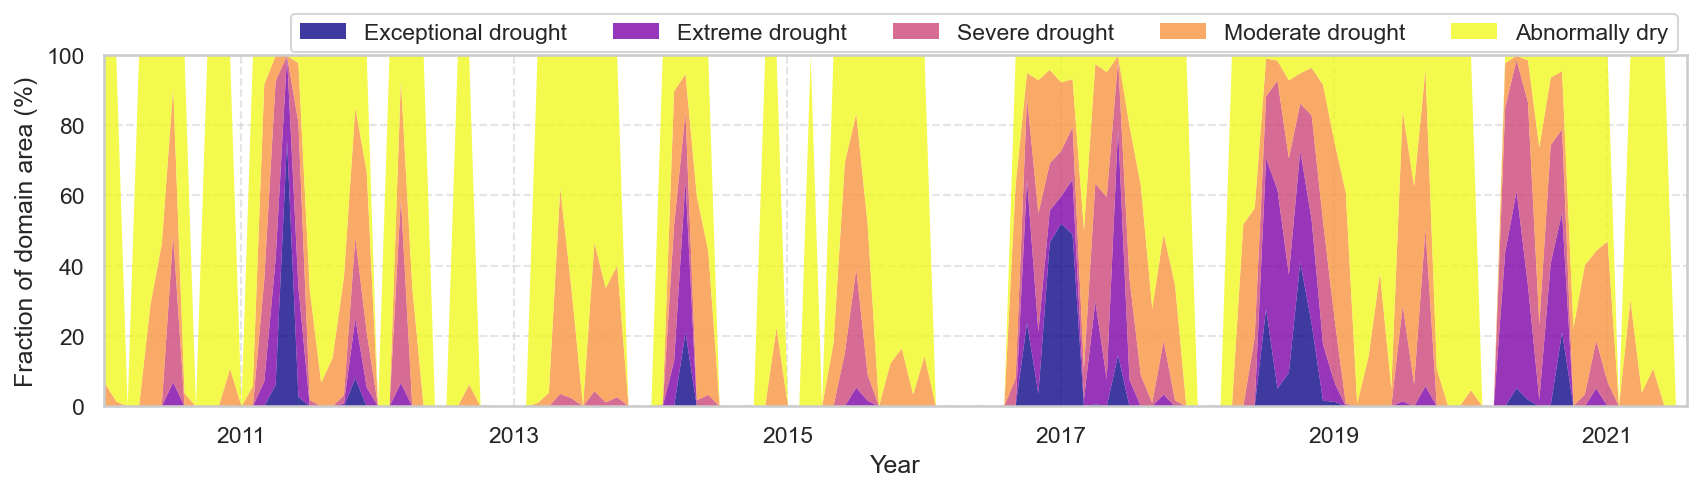

In [440]:
fig, ax = plt.subplots(figsize=(12, 3.5), dpi=150)
drought_percentile_df[480:620].plot.area(colormap='plasma', ax=ax, linewidth=0, alpha=0.8)
plt.ylabel('Fraction of domain area (%)')
plt.ylim(0, 100)
plt.legend(loc='upper center', bbox_to_anchor=(0.556, 1.15), ncol=5)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [444]:
smi_percentile_df[500:620]

,Exceptional drought,Extreme drought,Severe drought,Moderate drought,Abnormally dry,Normal conditions,Wetter than normal,Very wet,Extremely wet
Year,,,,,,,,,
2011-09-01,0.000000,0.000000,0.000000,0.266241,1.664004,39.869542,58.146965,0.053248,0.000000
2011-10-01,0.000000,0.212993,0.652290,9.038871,16.986155,69.968051,3.141640,0.000000,0.000000
2011-11-01,7.694356,16.267306,22.031416,35.476571,14.177316,4.353035,0.000000,0.000000,0.000000
2011-12-01,0.000000,4.818956,14.044196,40.934505,29.672524,10.529819,0.000000,0.000000,0.000000
2012-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,36.501597,63.498403,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
2021-04-01,0.000000,0.000000,0.000000,1.584132,38.951012,59.464856,0.000000,0.000000,0.000000
2021-05-01,0.000000,0.000000,0.000000,4.313099,35.782748,57.574547,2.329606,0.000000,0.000000
2021-06-01,0.000000,0.000000,0.000000,0.000000,1.371140,93.543663,5.085197,0.000000,0.000000


In [443]:
drought_percentile_df[500:620]

,Exceptional drought,Extreme drought,Severe drought,Moderate drought,Abnormally dry
Year,,,,,
2011-09-01,0.000000,0.000000,0.000000,13.793103,86.206897
2011-10-01,0.000000,0.792079,2.425743,33.613861,63.168317
2011-11-01,8.044537,17.007655,23.034099,37.091162,14.822547
2011-12-01,0.000000,5.386103,15.697069,45.752120,33.164708
2012-01-01,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2021-04-01,0.000000,0.000000,0.000000,3.908046,96.091954
2021-05-01,0.000000,0.000000,0.000000,10.756972,89.243028
2021-06-01,0.000000,0.000000,0.000000,0.000000,100.000000


In [ ]:
#categories by decade
decades = ['1971:1980', '1981:1990', '1991:2000', '2001:2010', '2011:2020']



